## Antoencoder plus GMM
### Import packages

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import torch
from torch import nn,optim
import random

C:\Users\yalin\anaconda3\envs\course_project\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X = pd.read_csv("Data_Correct.csv",header=None)
Y = pd.read_csv("Data_Incorrect.csv",header=None)
print(X.head())

        0         1         2         3         4         5         6    \
0 -0.007967 -0.007596 -0.007147 -0.006631 -0.006065 -0.005463 -0.004840   
1 -0.053214 -0.053852 -0.054411 -0.054885 -0.055271 -0.055564 -0.055759   
2 -0.011795 -0.011839 -0.011834 -0.011784 -0.011692 -0.011562 -0.011398   
3  0.053393  0.054030  0.054587  0.055059  0.055441  0.055730  0.055921   
4 -0.007061 -0.006686 -0.006235 -0.005719 -0.005152 -0.004551 -0.003930   

        7         8         9    ...       230       231       232       233  \
0 -0.004211 -0.003592 -0.002997  ...  0.022263  0.022386  0.022453  0.022462   
1 -0.055853 -0.055843 -0.055728  ...  0.060776  0.061385  0.061918  0.062374   
2 -0.011204 -0.010984 -0.010742  ... -0.019779 -0.019992 -0.020218 -0.020456   
3  0.056010  0.055994  0.055873  ... -0.060639 -0.061242 -0.061769 -0.062218   
4 -0.003304 -0.002689 -0.002098  ...  0.023281  0.023424  0.023513  0.023546   

        234       235       236       237       238       239  
0  0

In [3]:
X = X.to_numpy()
Y = Y.to_numpy()
print(X.shape)
print(Y.shape)

(10530, 240)
(10530, 240)


### Transform data to be in size (240x90)x117

In [4]:
n_dim = 117
T = X.shape[1]
R = int(X.shape[0]/n_dim)
X_NN = np.zeros((R,T,n_dim))
for r in range(R):
    X_NN[r,:,:] = X[r*n_dim:(r+1)*n_dim,:].T
print(X_NN.shape)

(90, 240, 117)


In [5]:
Y_NN = np.zeros((R,T,n_dim))
for r in range(R):
    Y_NN[r,:,:] = Y[r*n_dim:(r+1)*n_dim,:].T
print(Y_NN.shape)

(90, 240, 117)


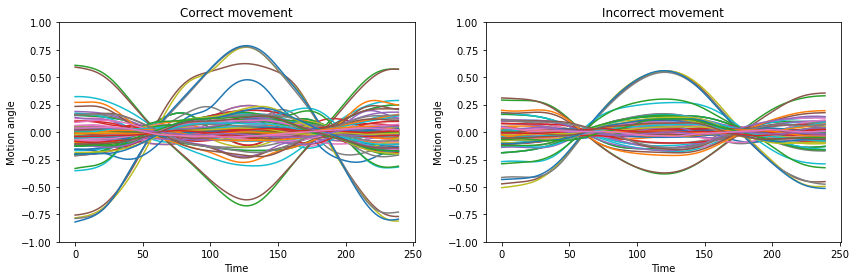

In [6]:
# Plot the first sequences of correct and incorrect data
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(X_NN[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Correct movement")
plt.subplot(1,2,2)
plt.plot(Y_NN[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Incorrect movement")
plt.tight_layout()
plt.show()

### Extend data
Add 50 time frames at the beginning and end of sequences as the autoencoder has difficulties with the beginning and ending frames.

In [7]:
'''
a = np.array([1,2,3,4])
print(a)
print(np.pad(a,2,'edge'))
'''

"\na = np.array([1,2,3,4])\nprint(a)\nprint(np.pad(a,2,'edge'))\n"

In [8]:
X_NN_add = np.zeros((R,T+100,n_dim))
for r in range(R):
    for d in range(n_dim):
        X_NN_add[r,:,d] = np.pad(X_NN[r,:,d],50,"edge")
print(X_NN_add.shape)

(90, 340, 117)


In [9]:
Y_NN_add = np.zeros((R,T+100,n_dim))
for r in range(R):
    for d in range(n_dim):
        Y_NN_add[r,:,d] = np.pad(Y_NN[r,:,d],50,"edge")
print(Y_NN_add.shape)

(90, 340, 117)


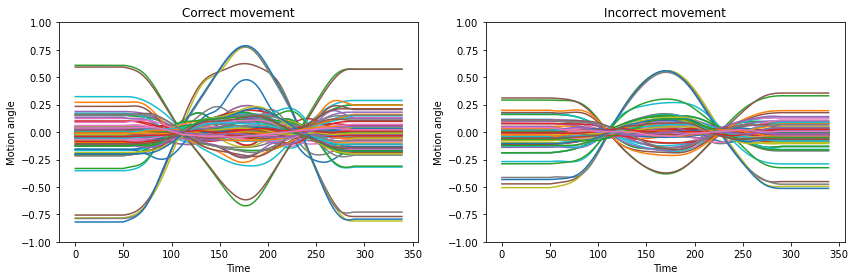

In [10]:
# Plot the first sequences of correct and incorrect data
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(X_NN_add[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Correct movement")
plt.subplot(1,2,2)
plt.plot(Y_NN_add[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Incorrect movement")
plt.tight_layout()
plt.show()

### Build autoencoder model
input = [batch_size,sen_len,input_size]

nn.LSTM(input_size, hidden_size, batch_first=True)

In [11]:
X_NN_add = torch.tensor(X_NN_add).float()
Y_NN_add = torch.tensor(Y_NN_add).float()

In [12]:
class AE(nn.Module):
    def __init__(self,n_dim):
        super().__init__()
        # encoder layers
        self.en1 = nn.LSTM(n_dim,30,batch_first=True)
        self.en2 = nn.LSTM(30,10,batch_first=True)
        self.en3 = nn.LSTM(10,4,batch_first=True)
        # decoder layers
        self.de1 = nn.LSTM(4,10,batch_first=True)
        self.de2 = nn.LSTM(10,30,batch_first=True)
        self.de3 = nn.LSTM(30,n_dim,batch_first=True)
        
    def forward(self,x):
        en,(_,_) = self.en1(x)
        en,(_,_) = self.en2(en)
        en,(_,_) = self.en3(en)
        de,(_,_) = self.de1(en)
        de,(_,_) = self.de2(de)
        de,(_,_) = self.de3(de)
        return en, de

In [13]:
ae = AE(n_dim)
print(ae)

AE(
  (en1): LSTM(117, 30, batch_first=True)
  (en2): LSTM(30, 10, batch_first=True)
  (en3): LSTM(10, 4, batch_first=True)
  (de1): LSTM(4, 10, batch_first=True)
  (de2): LSTM(10, 30, batch_first=True)
  (de3): LSTM(30, 117, batch_first=True)
)


In [14]:
en,de = ae(X_NN_add)
print(en.shape)
print(de.shape)

torch.Size([90, 340, 4])
torch.Size([90, 340, 117])


In [15]:
trainidx = random.sample(range(0,R),63)
# return index which is in np.arange(0,90,1) but not in trainidx
valididx = np.setdiff1d(np.arange(0,90,1),trainidx)
print("train index: ", trainidx)
print("valid index: ", valididx)

train index:  [54, 1, 46, 7, 24, 38, 65, 29, 51, 5, 56, 89, 2, 26, 74, 71, 8, 21, 39, 75, 55, 63, 32, 25, 49, 73, 18, 61, 28, 59, 22, 44, 53, 80, 31, 34, 70, 45, 57, 23, 12, 14, 11, 33, 19, 83, 10, 60, 17, 84, 58, 41, 86, 3, 43, 35, 78, 0, 15, 87, 85, 67, 62]
valid index:  [ 4  6  9 13 16 20 27 30 36 37 40 42 47 48 50 52 64 66 68 69 72 76 77 79
 81 82 88]


In [16]:
train = X_NN_add[trainidx,:,:]
valid = X_NN_add[valididx,:,:]
print(train.shape)
print(valid.shape)

torch.Size([63, 340, 117])
torch.Size([27, 340, 117])


### Train the autoencoder model

In [17]:
optimizer = optim.AdamW(ae.parameters())
mse = nn.MSELoss()

In [18]:
history = {"train":[],"valid":[]}
for i in tqdm(range(100)):
    
    # update network
    optimizer.zero_grad()
    _,de = ae(train)
    loss = mse(train,de)
    loss.backward()
    optimizer.step()
    history["train"].append(loss.item())
    
    # valid loss
    _,de_val = ae(valid)
    loss_val = mse(valid,de_val)
    history["valid"].append(loss_val.item())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


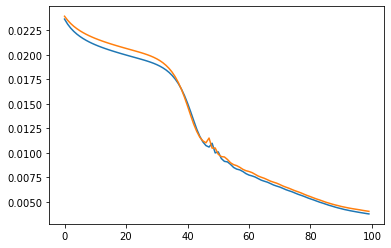

In [19]:
plt.plot(history["train"],label="train")
plt.plot(history["valid"],label="valid")
plt.show()

In [20]:
print(history["train"][-1])
print(history["valid"][-1])

0.0037717698141932487
0.004032915458083153


In [21]:
X_4,X_de = ae(X_NN_add)
Y_4,Y_de = ae(Y_NN_add)
X_4 = X_4.detach().numpy()
Y_4 = Y_4.detach().numpy()
X_de = X_de.detach().numpy()
Y_de = Y_de.detach().numpy()
print(X_4.shape)
print(X_de.shape)
print(Y_4.shape)
print(Y_de.shape)

(90, 340, 4)
(90, 340, 117)
(90, 340, 4)
(90, 340, 117)


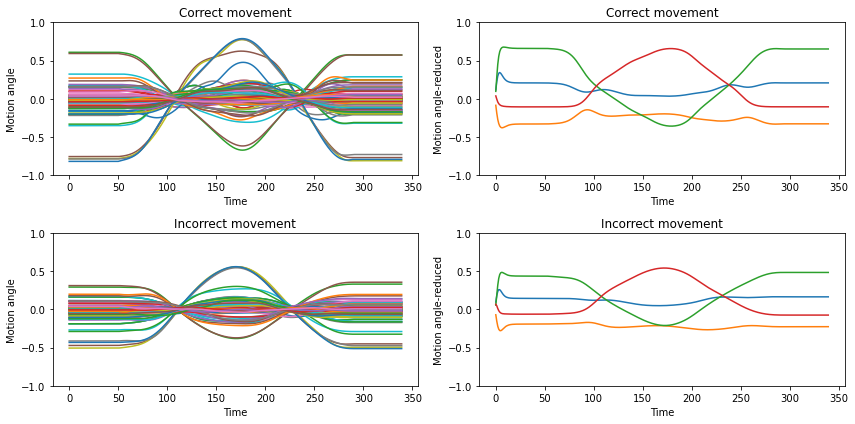

In [22]:
# Plot the first sequences of correct and incorrect data
plt.figure(figsize = (12,6))
#
plt.subplot(2,2,1)
plt.plot(X_NN_add[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Correct movement")
#
plt.subplot(2,2,2)
plt.plot(X_4[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle-reduced")
plt.title("Correct movement")
#
plt.subplot(2,2,3)
plt.plot(Y_NN_add[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle")
plt.title("Incorrect movement")
#
plt.subplot(2,2,4)
plt.plot(Y_4[0])
plt.ylim([-1,1])
plt.xlabel("Time")
plt.ylabel("Motion angle-reduced")
plt.title("Incorrect movement")
#
plt.tight_layout()
plt.show()

In [23]:
# remove the added first 50 and last 50 elements
X_4 = X_4[:,50:-50,:]
print(X_4.shape)

(90, 240, 4)
